In [1]:
import keras
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Input, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adagrad
from  keras.layers import Input
import cv2

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import skimage.morphology as morp
from skimage.filters import rank

In [3]:
from emnist import extract_training_samples
from emnist import extract_test_samples

Train_Qty = 60000
Test_Qty  = 10000

x, y = extract_training_samples('byclass')

x_train = x[:Train_Qty]
y_train = y[:Train_Qty]

xt, yt = extract_test_samples('byclass')
x_test = xt[:Test_Qty]
y_test = yt[:Test_Qty]

Das Bild zeigt : 8


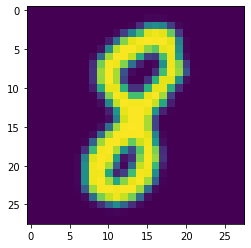

In [4]:
"""
Bilder und Labels zeigen und anpassen
"""
img_index = 8888 # das img_index. Image ausnehmen
img = x_train[img_index]
plt.imshow(img.reshape(28,28))

if y_train[img_index] <= 9:
    code = str(chr(y_train[img_index]+48))
    
elif y_train[img_index] <= 35:
    code = str(chr(y_train[img_index]+55))
    
else: 
    code = str(chr(y_train[img_index]+61))
    
print("Das Bild zeigt : " + code) 
    # 'chr' -> Von ASCII nach Schriftzeichen umschreiben
    
    #  0 <= y_train[img_index] <=  9 ist Zahlzeichen von 0 bis 9
    # 10 <= y_train[img_index] <= 35 ist Großbuchstabe von A bis Z
    # 36 <= y_train[img_index] <= 62 ist Kleinbuchstabe von a bis z

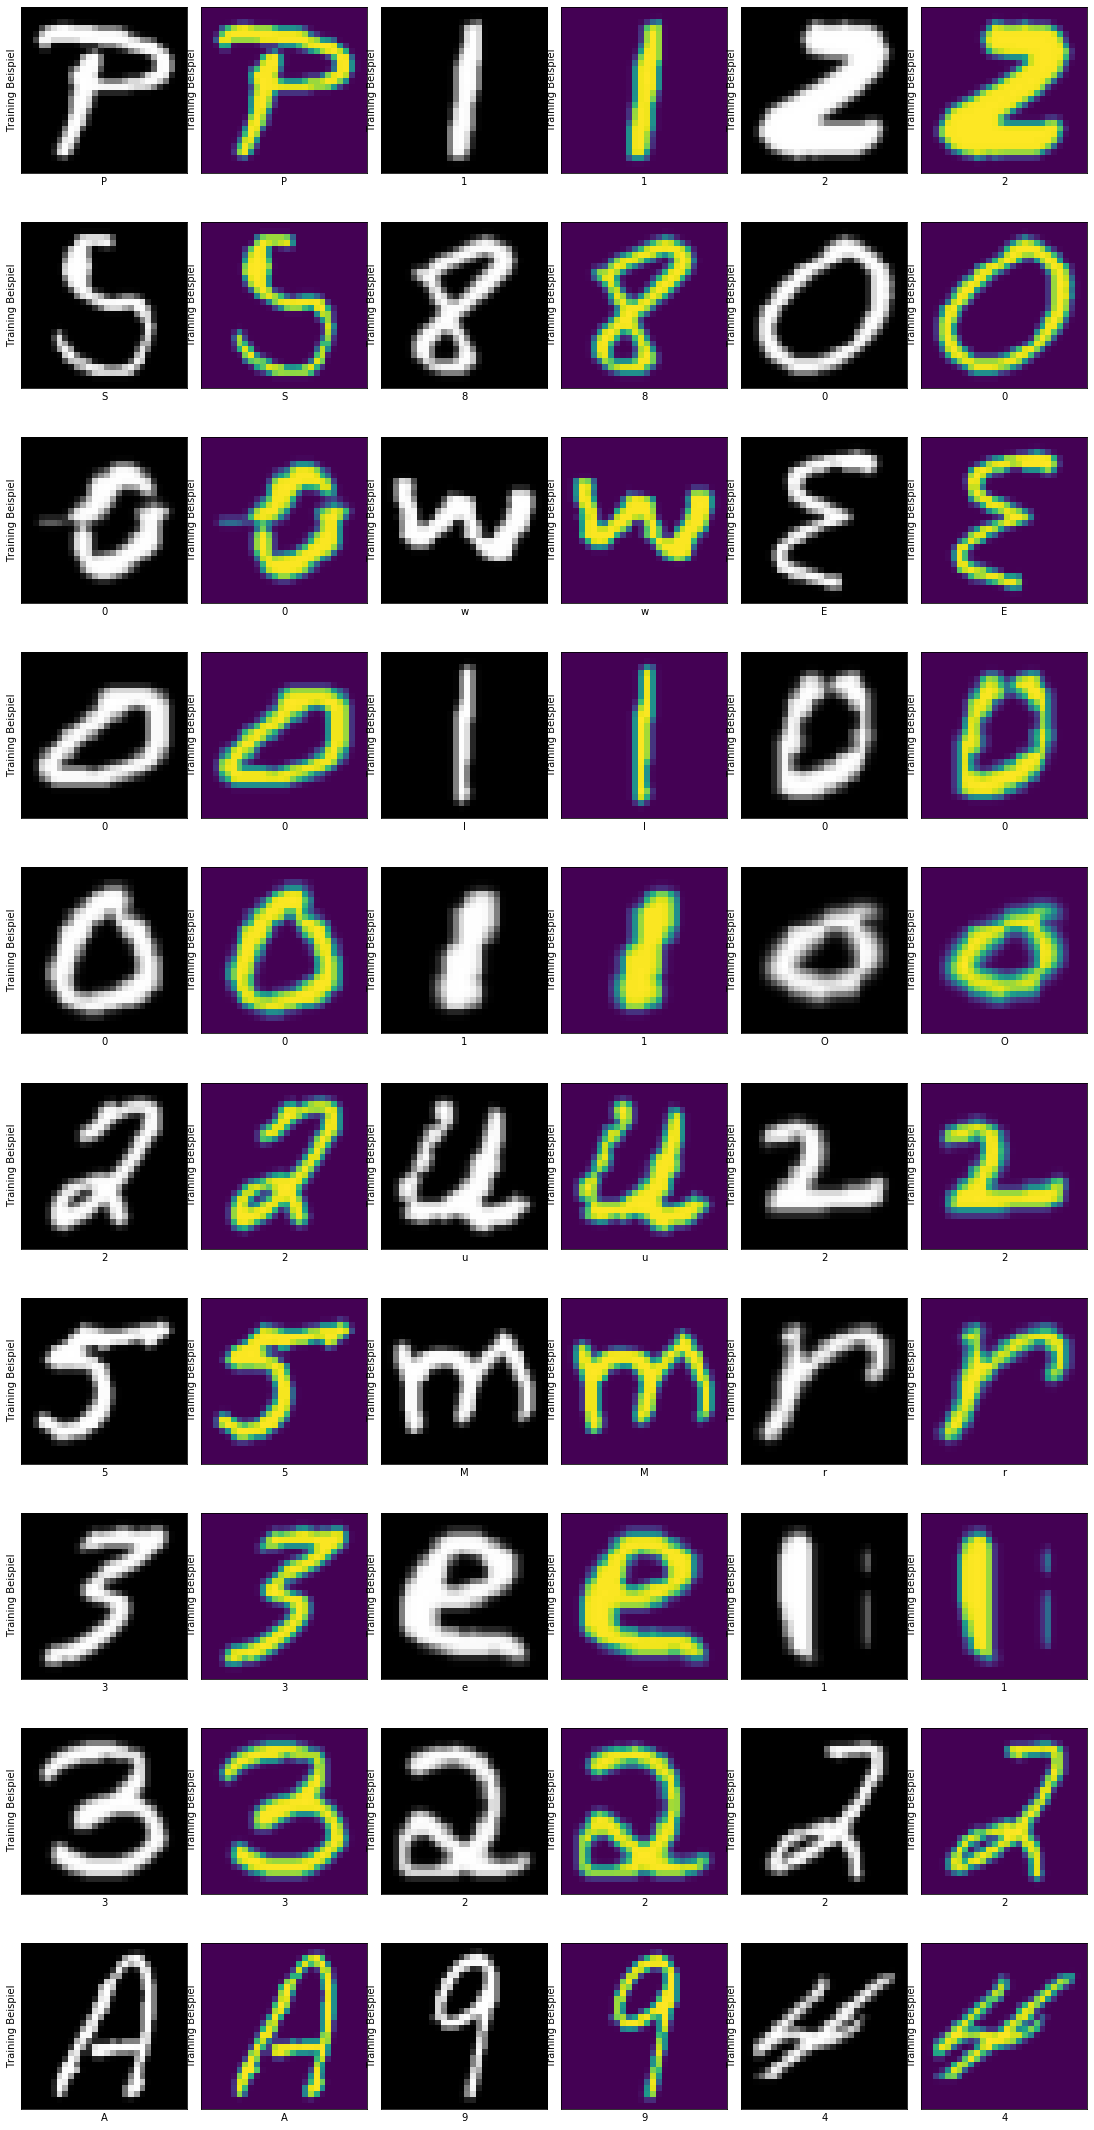

In [10]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    indx = []
    for i in range(30):
        indx.append(random.randint(0, len(dataset))) 
        # random.randint(0, len(dataset)): eine zufällige i herstellen. 0<=i<len(dateset)
    plt.figure(figsize=(15,30))
    for i in range(30):
        for j in range(2):
            plt.subplot(10, 6, 2*i+j+1)
            # Alle Bilder in eine 10 x 6 (Reihe x Spalt) zu zeigen
            # Use gray scale color map if there is only one channel
            cmap = 'gray' if len(dataset[indx[i]].shape) == 2 else cmap
            if j == 0:
                plt.imshow(dataset[indx[i]], cmap = cmap)
            else:    
                plt.imshow(dataset[indx[i]])
                
            if y_train[indx[i]] <= 9:
                x_axis = str(chr(y_train[indx[i]]+48))
            elif y_train[indx[i]] <= 35:
                x_axis = str(chr(y_train[indx[i]]+55))
            else: 
                x_axis = str(chr(y_train[indx[i]]+61))
            plt.xlabel(x_axis)
            plt.ylabel(ylabel)
            plt.xticks([])
            plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

list_images(x_train, y_train, "Training Beispiel", "gray")

In [11]:
n_train = x_train.shape[0]
n_test = x_test.shape[0]
image_shape = x_train[0].shape
n_classes = len(np.unique(y_train))
# Wiederholte Elemente von Vektor "y_rain" entfern, um die 62 Sort zu erhalten
random.seed(4242)

print("Anzahl der Trainingsbilder ----",n_train)
print("Anzahl der Testbilder ---------",n_test)
print("Bildformat --------------------",image_shape)
print("Anzahl der Klassen ------------",n_classes)

Anzahl der Trainingsbilder ---- 60000
Anzahl der Testbilder --------- 10000
Bildformat -------------------- (28, 28)
Anzahl der Klassen ------------ 62


In [12]:
"""
keras.applications.inception_v3 akzeptiert nur "3-channel" Bilder mit der Größe 224*224*3, 
Alle Bilder aus EMNIST Datensatz sind "1-channel" Bilder mit die Größe 28*28*1
Anbei sind alle Bilder ins 224*224*3 zu konversieren  
"""

# Bilder von 28*28 zu 224*224 zu vergrößen
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# jedes Pixel in allen Bildern einen Wert zwischen 0 und 1 transformieren
x_train /= 255
x_test /= 255
_x_train = []
_x_test = []

for x_tr in x_train:
    _x_train.append(cv2.resize(x_tr, (224, 224)))
for x_te in x_test:
    _x_test.append(cv2.resize(x_te, (224, 224)))
print(np.array(_x_train).shape)


_x_train = [cv2.cvtColor(cv2.resize(img,(224,224)),cv2.COLOR_GRAY2BGR) for img in _x_train]
_x_train = (np.asarray(_x_train))

_x_test = [cv2.cvtColor(cv2.resize(img,(224,224)),cv2.COLOR_GRAY2BGR) for img in _x_test]
_x_test = (np.asarray(_x_test))

print('x_train shape:', _x_train.shape)
print(_x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

(60000, 224, 224)
x_train shape: (60000, 224, 224, 3)
60000 train samples
10000 test samples


In [13]:
y_test_cat = np_utils.to_categorical(y_test, 62)
y_train_cat = np_utils.to_categorical(y_train, 62) 

In [14]:
BATCH_SIZE = 100
EPOCHS = 25
num_class = n_classes

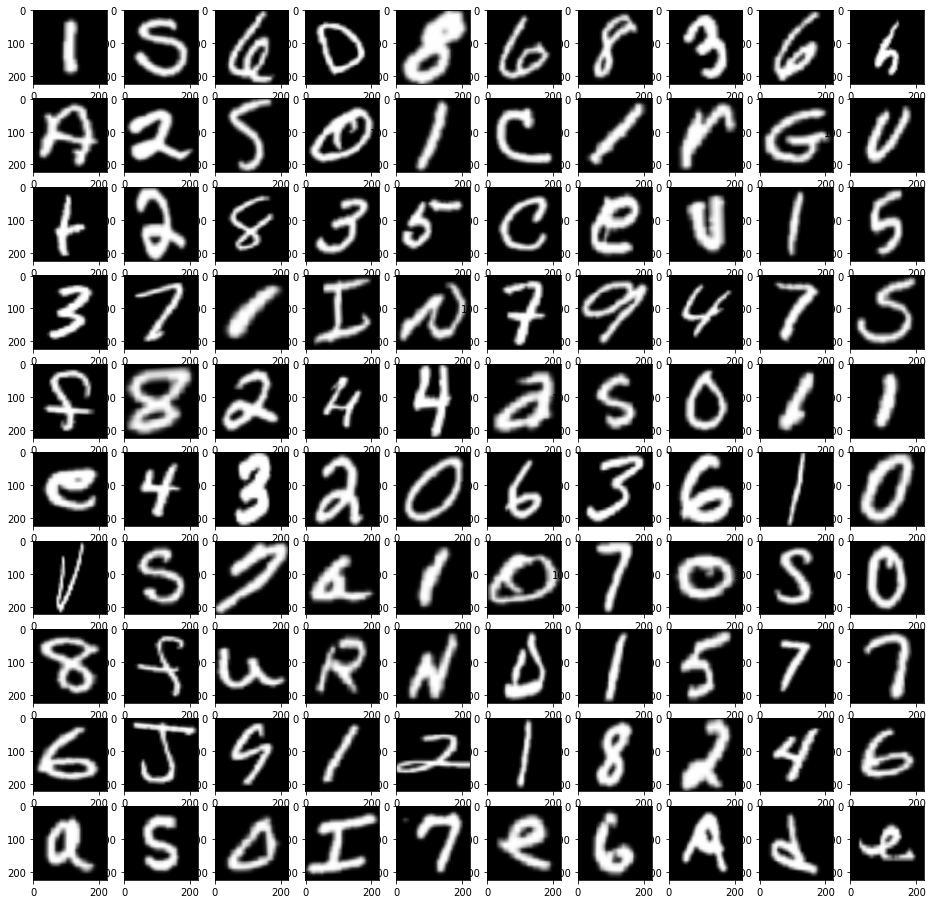

In [15]:
# “data generators” für Data Augumentation
train_datagen = ImageDataGenerator(shear_range=2, 
                                   zoom_range=0.2, 
                                   rotation_range=5, 
                                   width_shift_range=4, 
                                   height_shift_range=4, 
                                   featurewise_center=False, 
                                   samplewise_center=False, 
                                   featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False)

train_datagen.fit(_x_train)

plt.figure(figsize=(16,16))
for X_batch, y_batch in train_datagen.flow(_x_train, y_train_cat, batch_size=BATCH_SIZE):
    # 10x10 Bilder erstellen 
    for i in range(0, 100):
        plt.subplot(10,10,i+1)
        plt.imshow(X_batch[i].reshape(224, 224,3), cmap=plt.get_cmap('gray'))
    
    plt.show()
    break

train_generator = train_datagen.flow(_x_train, 
                                     y=y_train_cat, 
                                     batch_size=BATCH_SIZE)

In [16]:
def set_model_to_transfer_learning(model,base_model):
    for layer in base_model.layers:
        layer.trainable = False
        
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [17]:
def set_model_to_fine_tune(model,base_model):
    GAP_LAYER = 17
    for layer in base_model.layers[:GAP_LAYER+1]:
        layer.trainable = False
    for layer in base_model.layers[GAP_LAYER+1:]:
        layer.trainable = True
    model.compile(optimizer=Adagrad(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [18]:
base_model = InceptionV3(weights='imagenet',include_top=False)

W0610 00:23:07.997447 4607294912 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0610 00:23:08.020003 4607294912 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0610 00:23:08.023664 4607294912 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0610 00:23:08.040040 4607294912 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [19]:
base_output = base_model.output
global_average= GlobalAveragePooling2D()(base_output)
dense = Dense(128,activation='relu')(global_average)
output = Dense(62,activation='softmax')(dense)
model = Model(inputs=base_model.input,outputs=output)

In [ ]:
set_model_to_transfer_learning(model,base_model)
model.fit_generator(generator=train_generator,
                    steps_per_epoch=Train_Qty/BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight='auto')

In [ ]:
set_model_to_fine_tune(model,base_model)
model.fit_generator(generator=train_generator,
                    steps_per_epoch=Train_Qty/BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight='auto')

In [ ]:
score = model.evaluate(_x_test, y_test_cat)

print('Test-Ergebniss:')
print('Test loss/Fehler -----------', score[0])
print('Test accuracy/Genauigkeit --', score[1])